<a href="https://colab.research.google.com/github/artemk1337/DCGAN-label_embedding-MNIST/blob/master/DCGAN%2Bembedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.layers import (Dense, Conv2D, Conv2DTranspose, Flatten,
                                     MaxPool2D, GlobalAvgPool2D, LeakyReLU, 
                                     Reshape, Input, Embedding, multiply, 
                                     BatchNormalization, GlobalMaxPool2D)
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam, RMSprop

import numpy as np
from tqdm import tqdm


In [2]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
def normalize_img(image):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255.


X_train = normalize_img(X_train)
X_test = normalize_img(X_test)

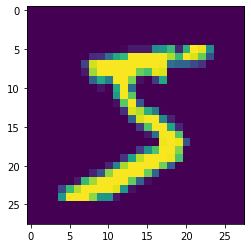

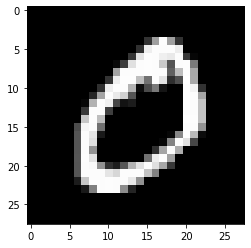

In [5]:
plt.imshow(X_train[0])
plt.show()
plt.imshow(X_train[1], cmap='gray')
plt.show()

In [6]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(7*7*512, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 512)))
    model.add(Conv2DTranspose(256, 4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, 4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(1, 4, strides=1, padding='same', activation='sigmoid'))
    return model


def create_embedding_g(output_dim):
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Embedding(10, output_dim)(label)
    label_embedding = Flatten()(label_embedding)
    return label, label_embedding


def build_generator_embedding(img_shape):
    z = Input(shape=(z_dim,))
    generator = build_generator(img_shape, z_dim)
    generator.summary()
    label, label_embedding = create_embedding_g(z_dim)
    img = generator(multiply([z, label_embedding]))
    generator = Model([z, label], img)
    return generator

In [7]:
def build_discriminator(img_shape, header=True):
    input = Input(shape=(img_shape))
    model = Conv2D(128, 4, strides=2, padding='same')(input)
    model = LeakyReLU(alpha=0.2)(model)
    model = Conv2D(256, 4, strides=2, padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Conv2D(512, 4, strides=2, padding='same')(model)
    model = GlobalMaxPool2D()(model)
    if header is True:
        model = Dense(1, activation='sigmoid')(model)
    output = model
    model = Model(input, output)
    return input, output, model


def create_embedding_d(output_shape):
    dim = lambda x, y, z: x*y*z
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Embedding(10, dim(*output_shape))(label)
    label_embedding = Reshape(output_shape)(label_embedding)
    model = Model(label, label_embedding)
    return label, label_embedding, model


def build_discriminator_embedding(img_shape):
    img_d = Input(shape=(img_shape))
    input_label, output_label, model_label = create_embedding_d(img_shape)
    # model_label.summary()

    input_discriminator, output_discriminator, model_discriminator = build_discriminator(img_shape, True)
    model_discriminator.summary()

    multiplied = multiply([img_d, output_label])
    final_output = model_discriminator(multiplied)
    model = Model([img_d, input_label], final_output)
    return model

In [8]:
def build_gan(generator, discriminator, z_dim):
    discriminator.trainable = False
    gan_input_dim = Input(shape=(z_dim,))
    gan_input_label = Input(shape=(1,), dtype='int32')
    gan_input = [gan_input_dim, gan_input_label]
    x = generator(gan_input)
    gan_output = discriminator([x, gan_input_label])
    gan = Model(inputs=gan_input, outputs=gan_output)
    return gan

In [40]:
generator = build_generator_embedding(img_shape)
# generator.summary()

discriminator = build_discriminator_embedding(img_shape)
# discriminator.summary()

optimizer = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

optimizer = Adam(lr=0.0002, beta_1=0.5)
gan = build_gan(generator, discriminator, z_dim)
gan.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 25088)             2533888   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 25088)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 512)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 256)       2097408   
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 128)       524416    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 28, 28, 128)      

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 1/100, d_loss=0.391, g_loss=2.519                                                                                                     


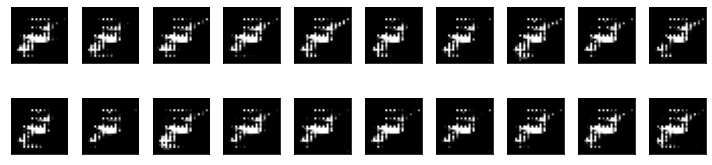

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 2/100, d_loss=0.688, g_loss=0.822                                                                                                     


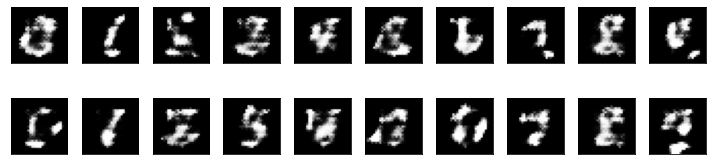

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 3/100, d_loss=0.689, g_loss=0.792                                                                                                     


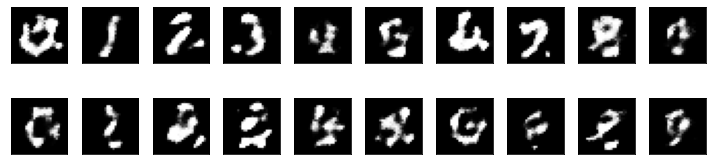

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 4/100, d_loss=0.686, g_loss=0.803                                                                                                     


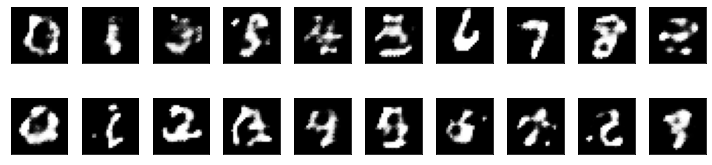

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 5/100, d_loss=0.684, g_loss=0.798                                                                                                     


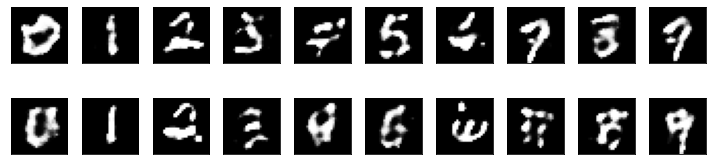

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 6/100, d_loss=0.687, g_loss=0.798                                                                                                     


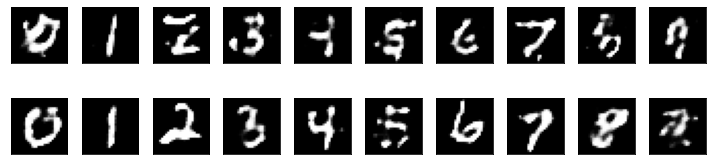

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 7/100, d_loss=0.687, g_loss=0.795                                                                                                     


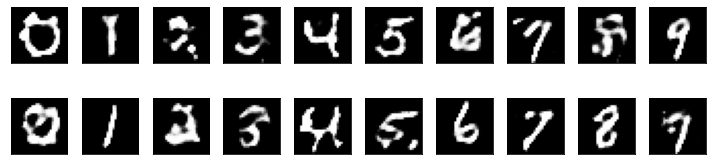

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 8/100, d_loss=0.688, g_loss=0.790                                                                                                     


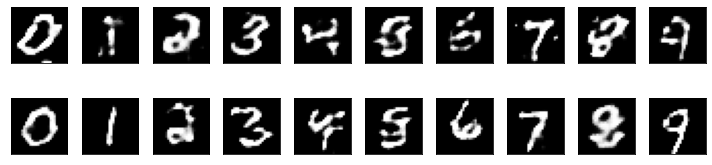

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 9/100, d_loss=0.687, g_loss=0.790                                                                                                     


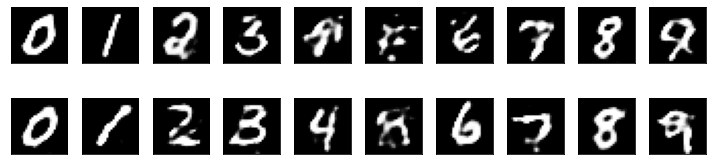

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 10/100, d_loss=0.685, g_loss=0.789                                                                                                     


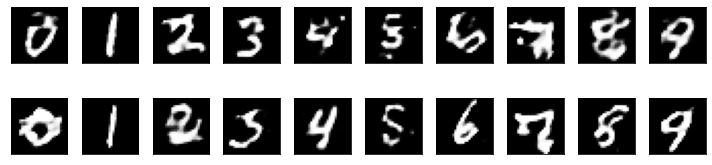

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 11/100, d_loss=0.689, g_loss=0.788                                                                                                     


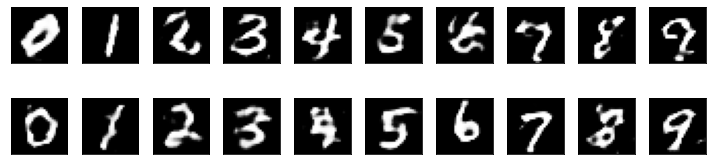

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 12/100, d_loss=0.683, g_loss=0.792                                                                                                     


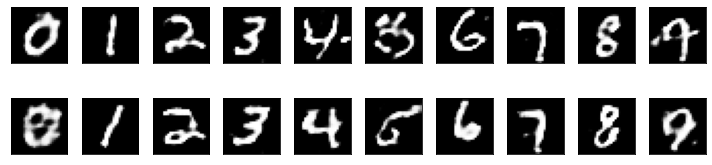

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 13/100, d_loss=0.684, g_loss=0.798                                                                                                     


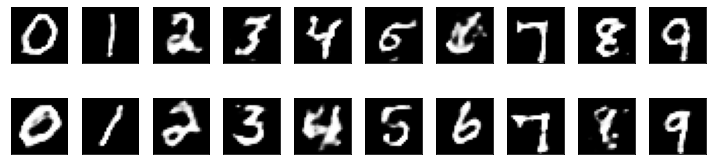

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 14/100, d_loss=0.684, g_loss=0.788                                                                                                     


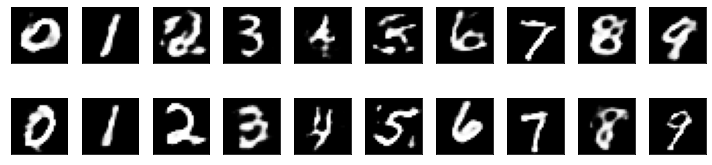

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 15/100, d_loss=0.685, g_loss=0.786                                                                                                     


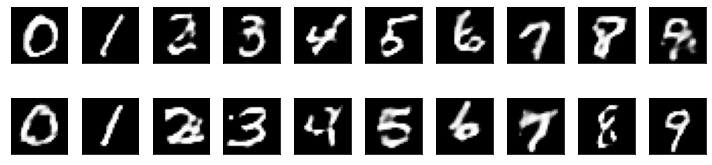

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 16/100, d_loss=0.683, g_loss=0.785                                                                                                     


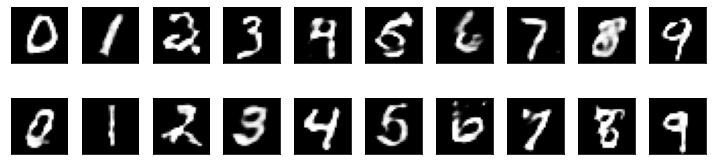

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 17/100, d_loss=0.685, g_loss=0.789                                                                                                     


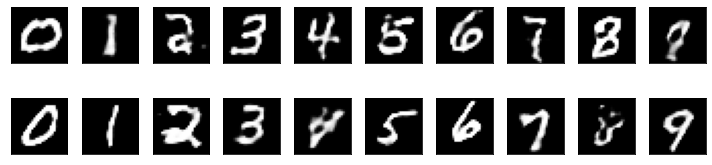

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 18/100, d_loss=0.686, g_loss=0.793                                                                                                     


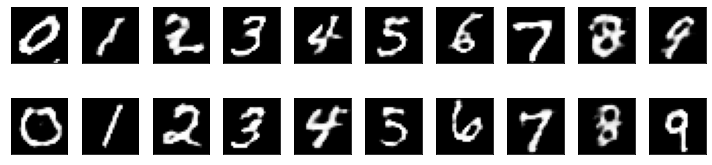

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 19/100, d_loss=0.687, g_loss=0.785                                                                                                     


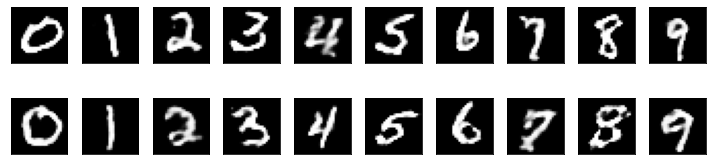

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 20/100, d_loss=0.683, g_loss=0.788                                                                                                     


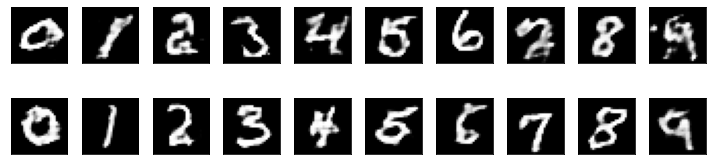

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 21/100, d_loss=0.685, g_loss=0.794                                                                                                     


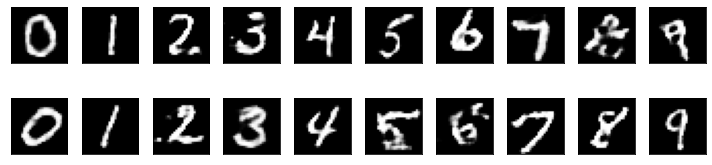

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 22/100, d_loss=0.689, g_loss=0.787                                                                                                     


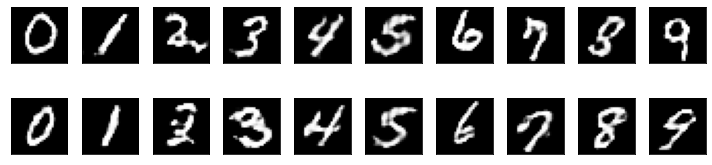

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 23/100, d_loss=0.684, g_loss=0.786                                                                                                     


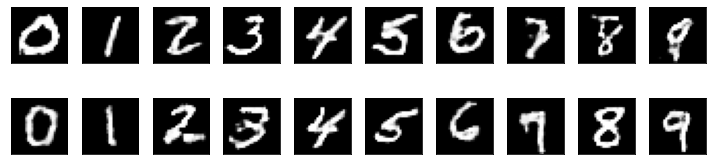

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 24/100, d_loss=0.686, g_loss=0.786                                                                                                     


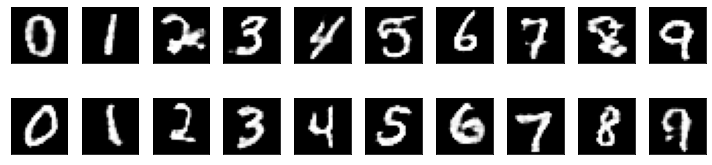

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 25/100, d_loss=0.682, g_loss=0.778                                                                                                     


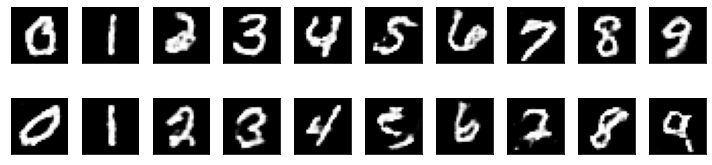

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 26/100, d_loss=0.686, g_loss=0.782                                                                                                     


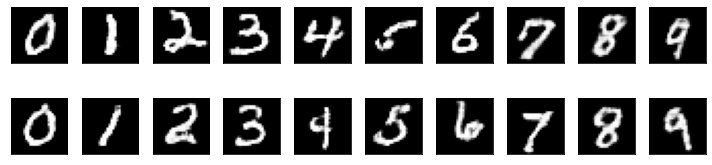

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 27/100, d_loss=0.687, g_loss=0.789                                                                                                     


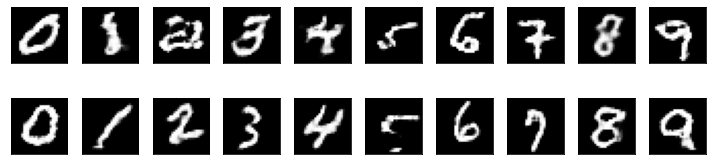

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 28/100, d_loss=0.685, g_loss=0.774                                                                                                     


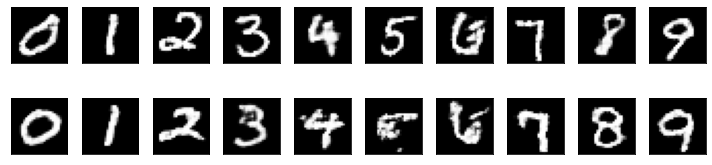

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 29/100, d_loss=0.683, g_loss=0.773                                                                                                     


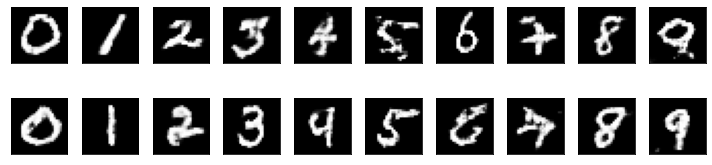

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 30/100, d_loss=0.686, g_loss=0.764                                                                                                     


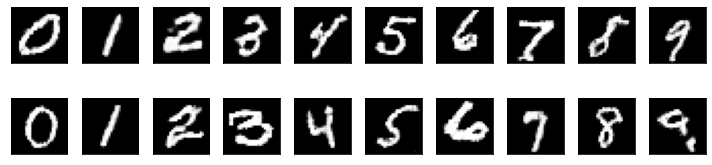

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 31/100, d_loss=0.682, g_loss=0.762                                                                                                     


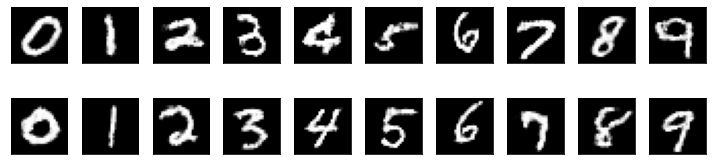

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 32/100, d_loss=0.684, g_loss=0.767                                                                                                     


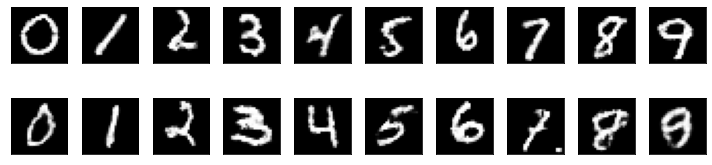

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 33/100, d_loss=0.681, g_loss=0.763                                                                                                     


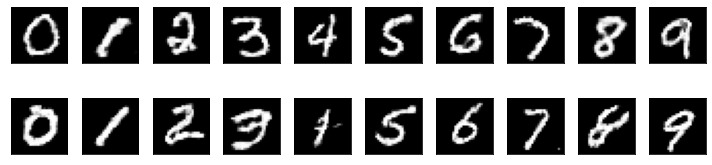

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 34/100, d_loss=0.680, g_loss=0.778                                                                                                     


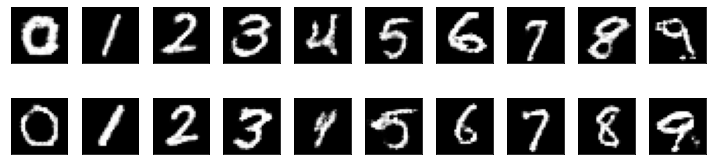

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 35/100, d_loss=0.678, g_loss=0.767                                                                                                     


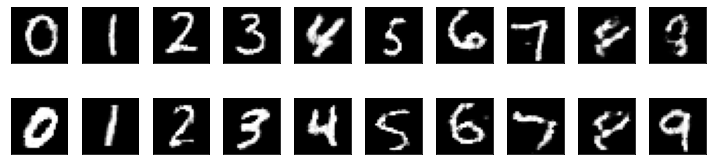

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 36/100, d_loss=0.681, g_loss=0.770                                                                                                     


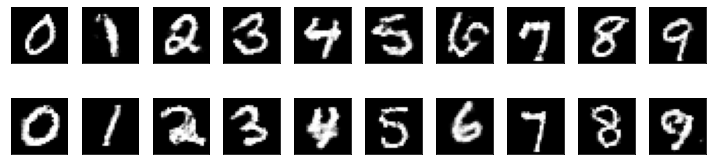

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 37/100, d_loss=0.684, g_loss=0.777                                                                                                     


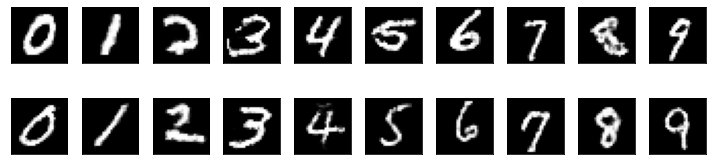

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 38/100, d_loss=0.680, g_loss=0.780                                                                                                     


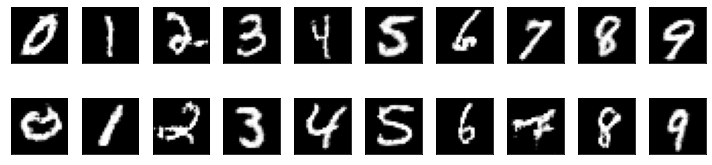

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 39/100, d_loss=0.678, g_loss=0.764                                                                                                     


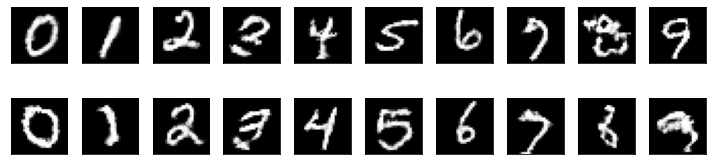

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 40/100, d_loss=0.680, g_loss=0.773                                                                                                     


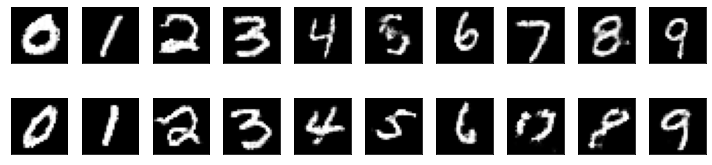

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 41/100, d_loss=0.685, g_loss=0.766                                                                                                     


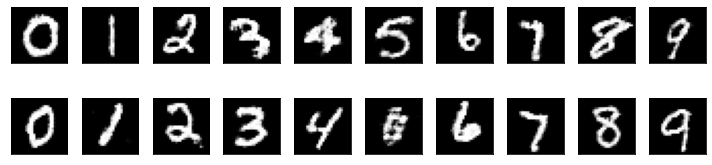

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 42/100, d_loss=0.683, g_loss=0.759                                                                                                     


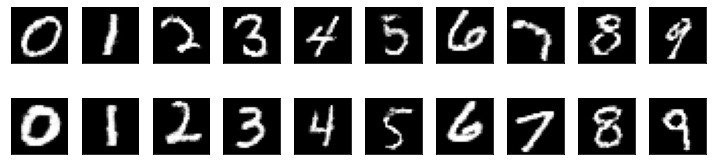

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 43/100, d_loss=0.682, g_loss=0.766                                                                                                     


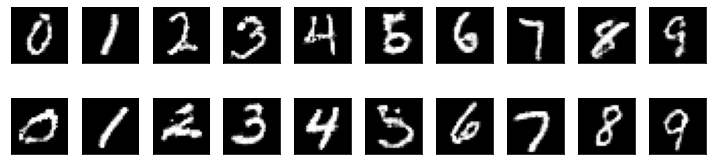

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 44/100, d_loss=0.686, g_loss=0.765                                                                                                     


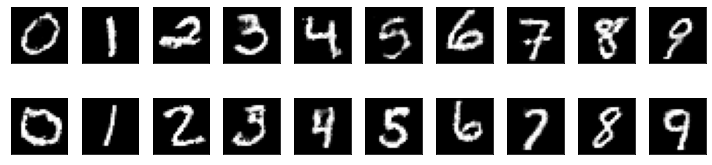

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 45/100, d_loss=0.686, g_loss=0.764                                                                                                     


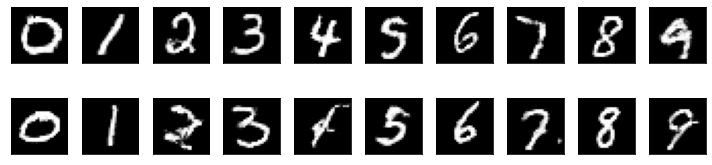

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 46/100, d_loss=0.680, g_loss=0.761                                                                                                     


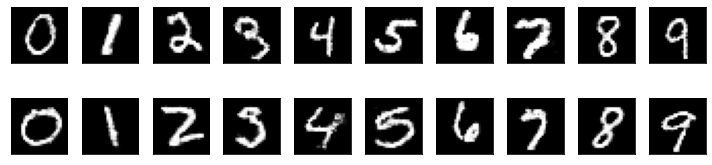

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 47/100, d_loss=0.686, g_loss=0.758                                                                                                     


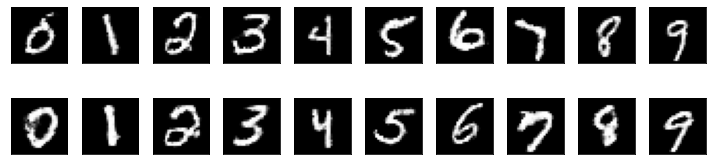

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 48/100, d_loss=0.684, g_loss=0.762                                                                                                     


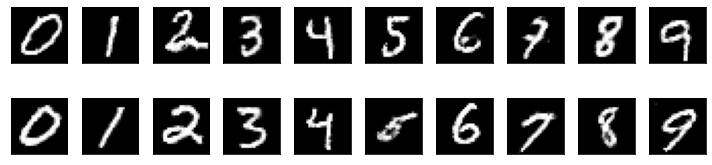

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 49/100, d_loss=0.682, g_loss=0.760                                                                                                     


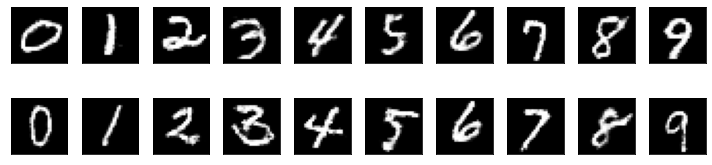

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 50/100, d_loss=0.686, g_loss=0.762                                                                                                     


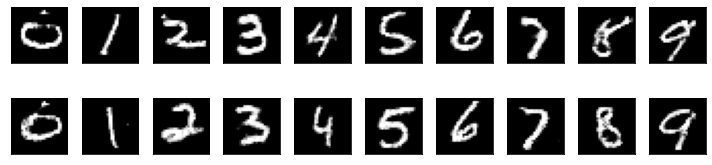

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 51/100, d_loss=0.682, g_loss=0.763                                                                                                     


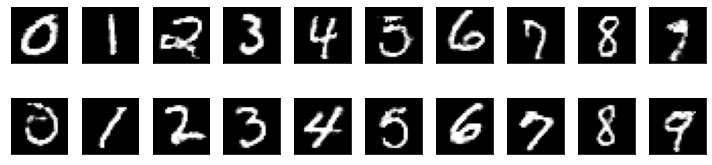

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 52/100, d_loss=0.682, g_loss=0.771                                                                                                     


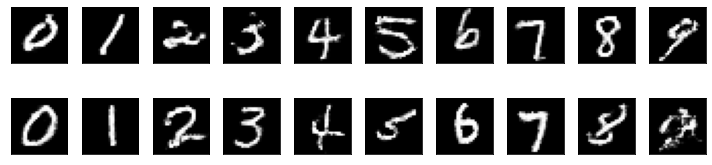

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 53/100, d_loss=0.680, g_loss=0.773                                                                                                     


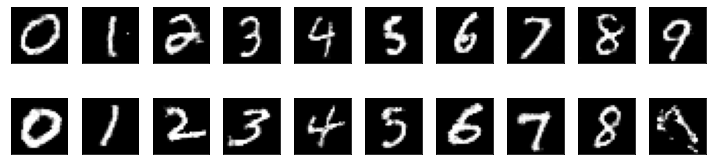

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 54/100, d_loss=0.682, g_loss=0.761                                                                                                     


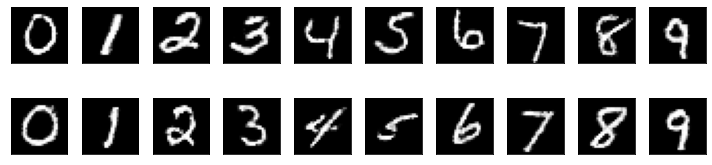

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 55/100, d_loss=0.674, g_loss=0.773                                                                                                     


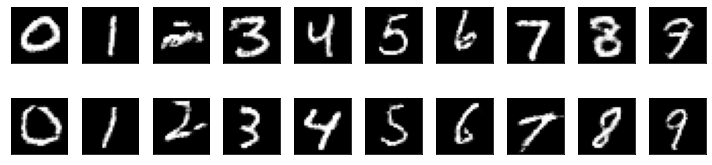

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 56/100, d_loss=0.678, g_loss=0.769                                                                                                     


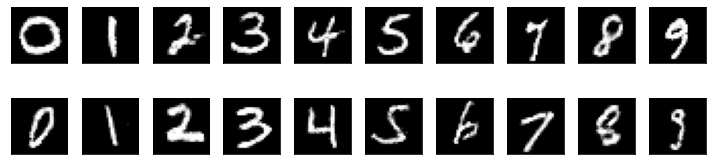

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 57/100, d_loss=0.676, g_loss=0.759                                                                                                     


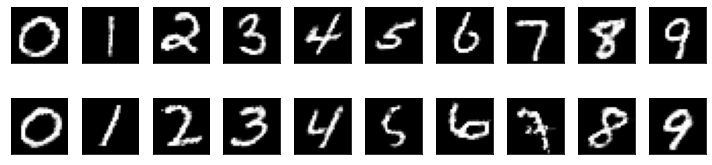

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 58/100, d_loss=0.677, g_loss=0.771                                                                                                     


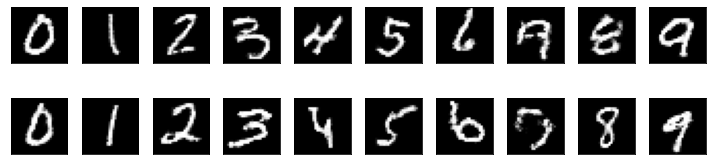

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 59/100, d_loss=0.681, g_loss=0.760                                                                                                     


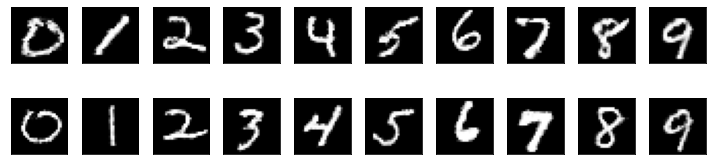

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 60/100, d_loss=0.679, g_loss=0.763                                                                                                     


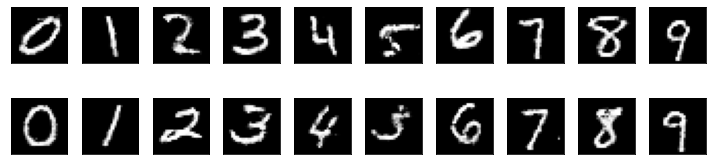

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 61/100, d_loss=0.679, g_loss=0.765                                                                                                     


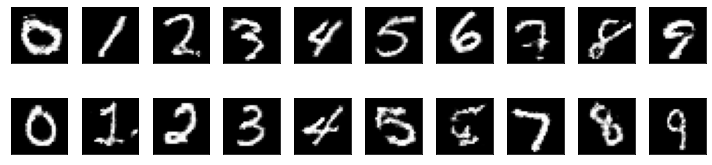

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 62/100, d_loss=0.682, g_loss=0.776                                                                                                     


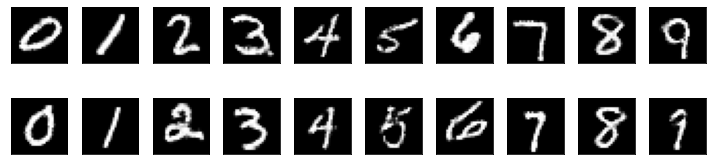

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 63/100, d_loss=0.675, g_loss=0.769                                                                                                     


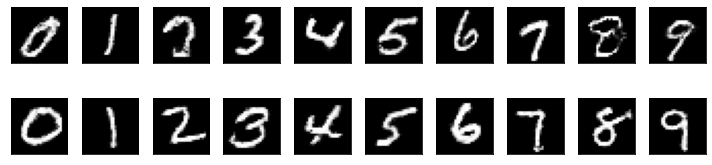

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 64/100, d_loss=0.672, g_loss=0.767                                                                                                     


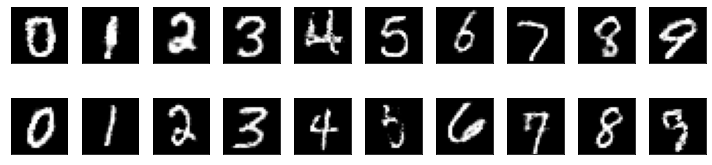

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 65/100, d_loss=0.674, g_loss=0.769                                                                                                     


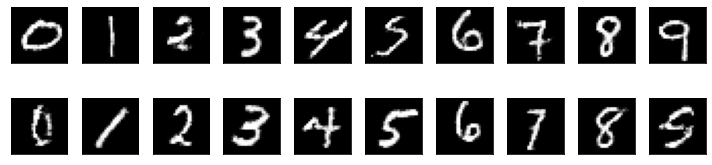

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 66/100, d_loss=0.679, g_loss=0.760                                                                                                     


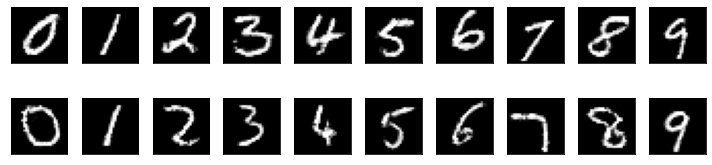

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 67/100, d_loss=0.677, g_loss=0.756                                                                                                     


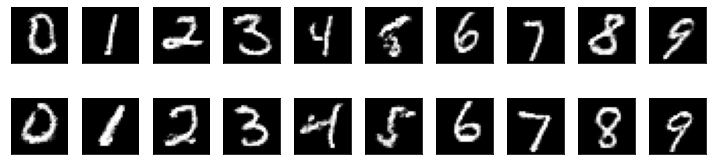

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 68/100, d_loss=0.679, g_loss=0.769                                                                                                     


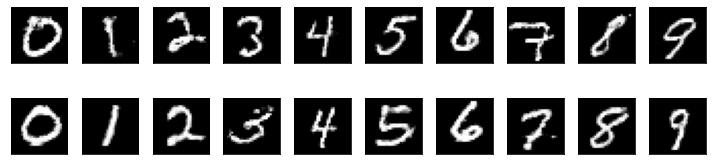

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 69/100, d_loss=0.682, g_loss=0.762                                                                                                     


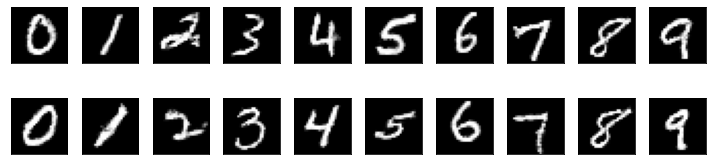

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 70/100, d_loss=0.676, g_loss=0.764                                                                                                     


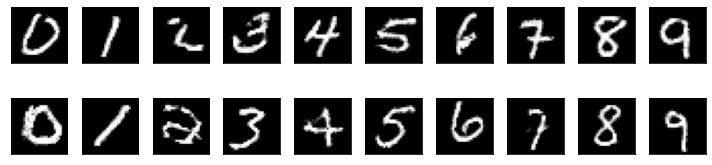

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 71/100, d_loss=0.675, g_loss=0.780                                                                                                     


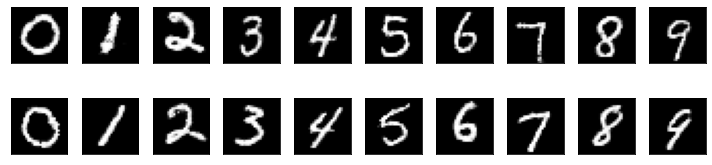

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 72/100, d_loss=0.670, g_loss=0.776                                                                                                     


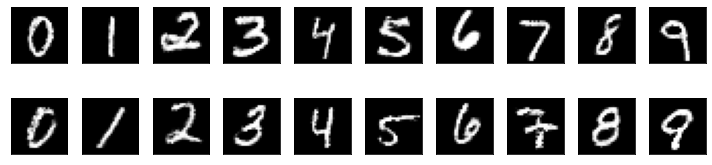

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 73/100, d_loss=0.674, g_loss=0.780                                                                                                     


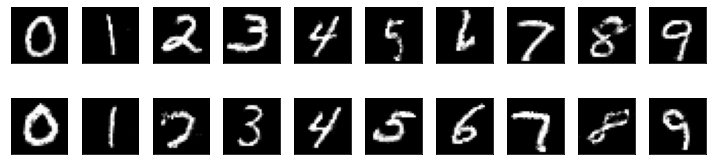

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 74/100, d_loss=0.670, g_loss=0.765                                                                                                     


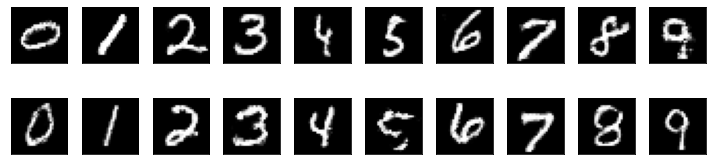

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 75/100, d_loss=0.674, g_loss=0.778                                                                                                     


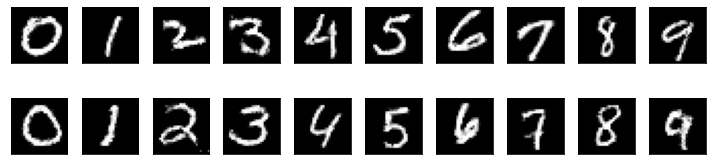

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 76/100, d_loss=0.674, g_loss=0.787                                                                                                     


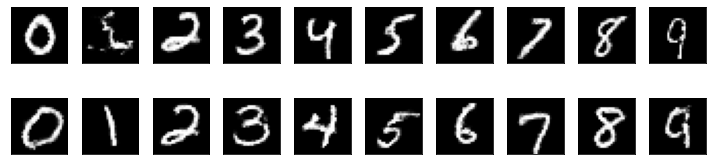

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 77/100, d_loss=0.665, g_loss=0.801                                                                                                     


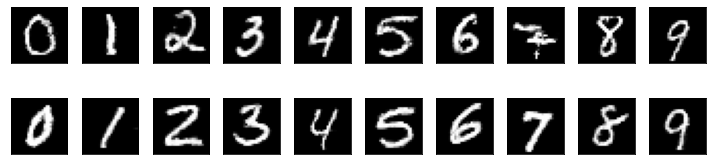

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 78/100, d_loss=0.667, g_loss=0.784                                                                                                     


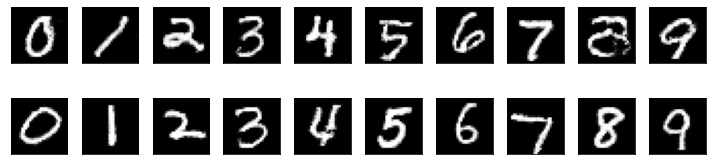

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 79/100, d_loss=0.667, g_loss=0.789                                                                                                     


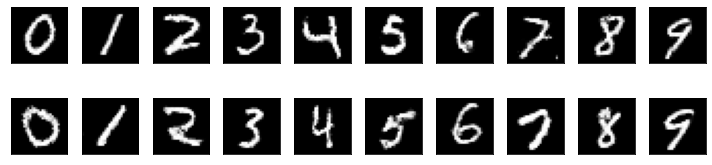

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 80/100, d_loss=0.661, g_loss=0.781                                                                                                     


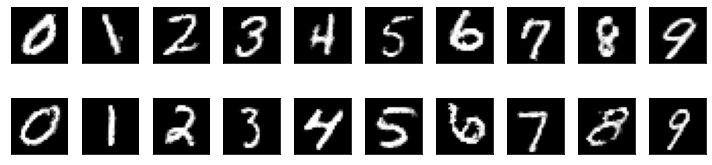

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 81/100, d_loss=0.669, g_loss=0.784                                                                                                     


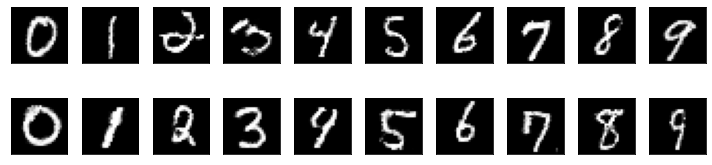

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 82/100, d_loss=0.656, g_loss=0.796                                                                                                     


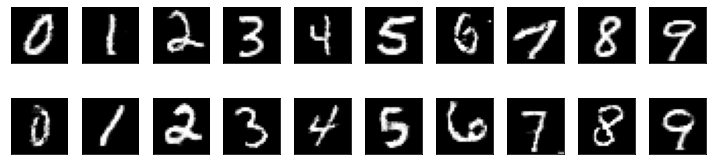

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 83/100, d_loss=0.662, g_loss=0.789                                                                                                     


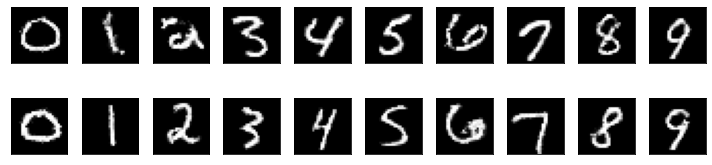

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 84/100, d_loss=0.656, g_loss=0.827                                                                                                     


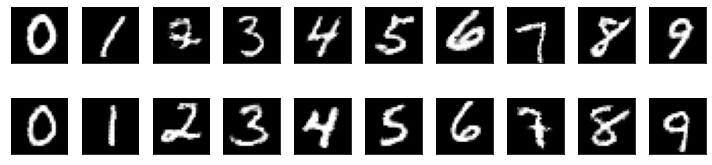

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 85/100, d_loss=0.661, g_loss=0.831                                                                                                     


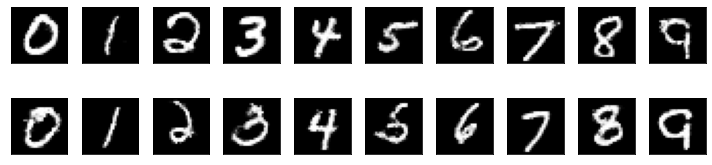

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 86/100, d_loss=0.661, g_loss=0.833                                                                                                     


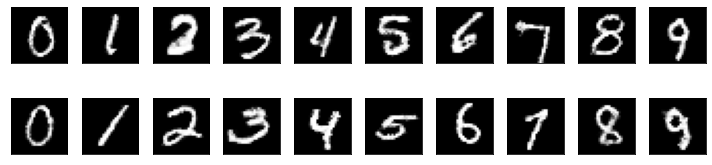

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 87/100, d_loss=0.646, g_loss=0.810                                                                                                     


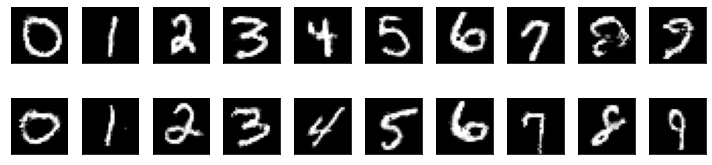

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 88/100, d_loss=0.653, g_loss=0.818                                                                                                     


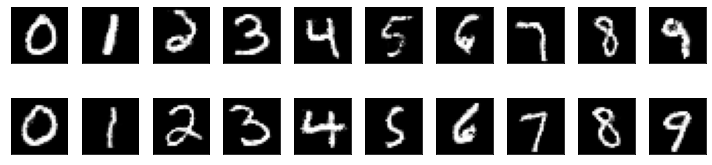

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 89/100, d_loss=0.648, g_loss=0.840                                                                                                     


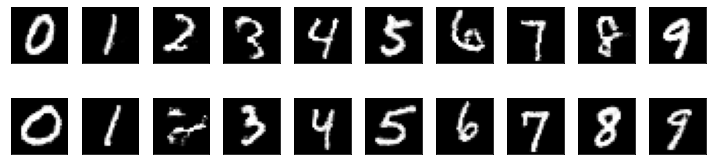

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 90/100, d_loss=0.655, g_loss=0.833                                                                                                     


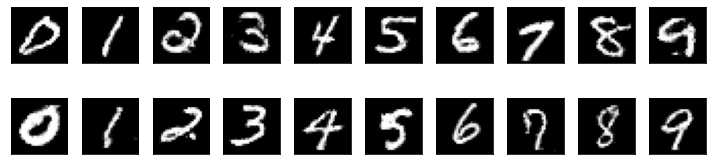

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 91/100, d_loss=0.647, g_loss=0.865                                                                                                     


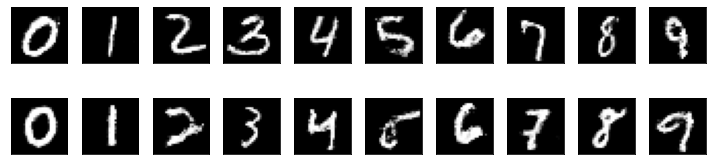

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 92/100, d_loss=0.644, g_loss=0.868                                                                                                     


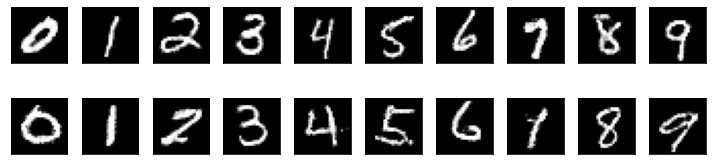

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 93/100, d_loss=0.629, g_loss=0.886                                                                                                     


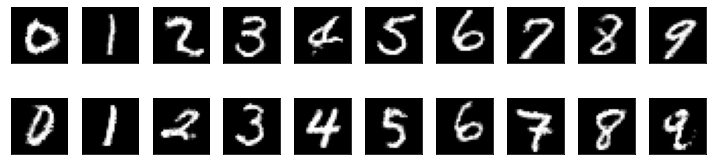

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 94/100, d_loss=0.652, g_loss=0.869                                                                                                     


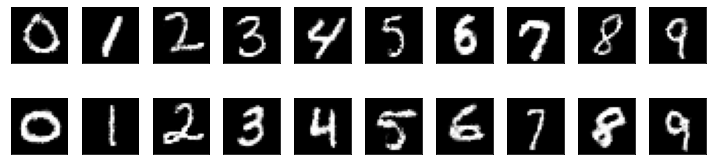

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 95/100, d_loss=0.628, g_loss=0.835                                                                                                     


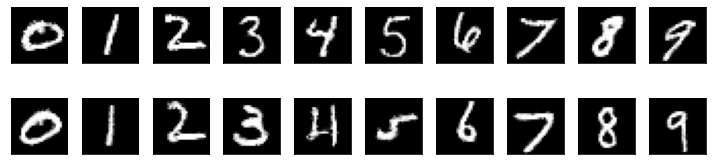

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 96/100, d_loss=0.632, g_loss=0.910                                                                                                     


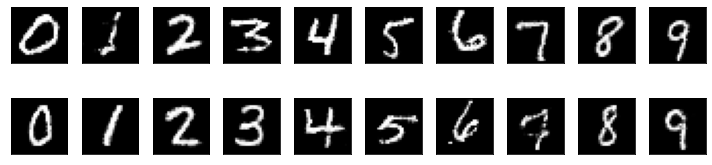

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 97/100, d_loss=0.644, g_loss=0.864                                                                                                     


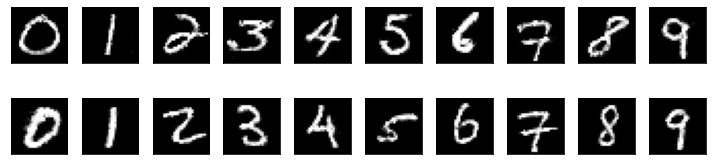

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 98/100, d_loss=0.627, g_loss=0.912                                                                                                     


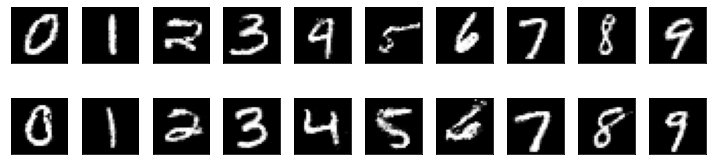

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 99/100, d_loss=0.639, g_loss=0.882                                                                                                     


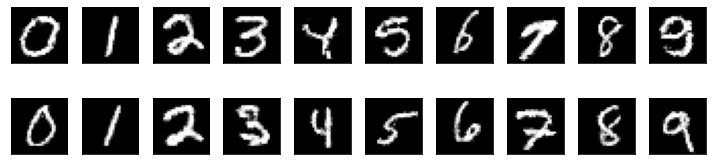

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 100/100, d_loss=0.648, g_loss=0.934                                                                                                     


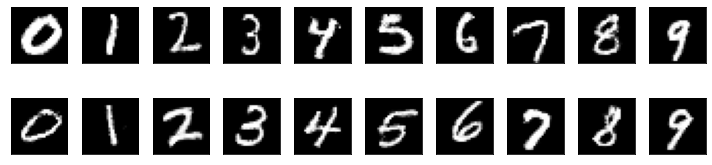

Step 0
Step 50
Step 100
Step 150
Step 200
epoch = 101/100, d_loss=0.638, g_loss=0.896                                                                                                     


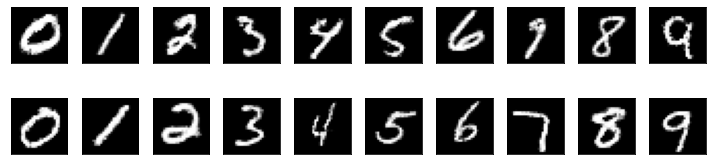

In [41]:
epochs = 100
batch_size = 256
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

# X_train =  X_train[:20000]
for e in range(epochs + 1):
    smooth *= 0.99
    for i in range(len(X_train) // batch_size):
        # Train Discriminator weights
        discriminator.trainable = True
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1)
        # d_loss_real = discriminator.fit(x=[X_batch, real_labels], y=real * (1 - smooth), epochs=1)
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels], y=real * (1 - smooth))
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, z_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

        # Train Generator weights
        discriminator.trainable = False
        z = np.random.normal(loc=0, scale=1, size=(batch_size, z_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        d_g_loss_batch = gan.train_on_batch(x=[z, random_labels], y=real)

        if i % 50 == 0:
            print(f'Step {i}')
        """if i % 50 == 0:
            samples = 10
            z = np.random.normal(loc=0, scale=1, size=(samples, z_dim))
            labels = np.arange(0, 10).reshape(-1, 1)
            x_fake = generator.predict([z, labels])
            for k in range(samples):
                plt.subplot(2, 5, k+1)
                plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
                plt.xticks([])
                plt.yticks([])

            plt.tight_layout()
            plt.show()"""
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 1 == 0:
        samples = 20
        z = np.random.normal(loc=0, scale=1, size=(samples, z_dim))
        labels = np.concatenate((np.arange(0, 10).reshape(-1, 1), np.arange(0, 10).reshape(-1, 1)), axis=0)

        x_fake = generator.predict([z, labels])

        plt.figure(figsize=(10,3))
        for k in range(samples):
            plt.subplot(2, 10, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.savefig('./' + f'{e}_epoch.png')
        plt.show()

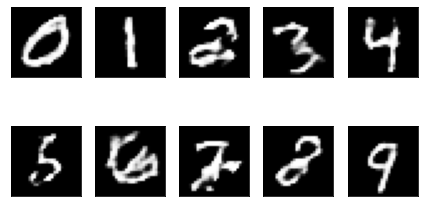

In [39]:
samples = 10

z = np.random.normal(loc=0, scale=1, size=(samples, z_dim))
labels = np.arange(0, 10).reshape(-1, 1)
x_fake = generator.predict([z, labels])

for k in range(samples):
    plt.subplot(2, 5, k+1)
    plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

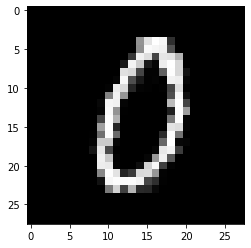

In [12]:
label = 0

z = np.random.normal(loc=0, scale=1, size=(1, z_dim))
labels = np.array([label]).reshape(-1, 1)
x_fake = generator.predict([z, labels])
plt.imshow(x_fake[0].reshape(28, 28), cmap='gray')
plt.show()